In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
data_path = "data/"
places = pd.read_csv(data_path + "places.csv", sep=";")
reviews = pd.read_csv(data_path + "reviews.csv", sep=";", low_memory=False)

In [4]:
print("Shape of places:", places.shape)
places.isna().sum()

Shape of places: (102851, 8)


name                0
price           72365
address             0
hours           37448
phone            4461
closed              0
gPlusPlaceId        0
gps              1251
dtype: int64

In [5]:
print("Shape of reviews:", reviews.shape)
reviews.isna().sum()

Shape of reviews: (571724, 8)


rating                 0
reviewerName        2139
reviewText        146604
categories         50096
gPlusPlaceId        3885
unixReviewTime     49070
reviewTime         50817
gPlusUserId         5632
dtype: int64

In [9]:
# Only get reviews that are in the places list
reviews = reviews.loc[lambda x: x.gPlusPlaceId.isin(places.gPlusPlaceId.values)]

In [6]:
reviews['rating'] = pd.to_numeric(reviews['rating'], errors="coerce")

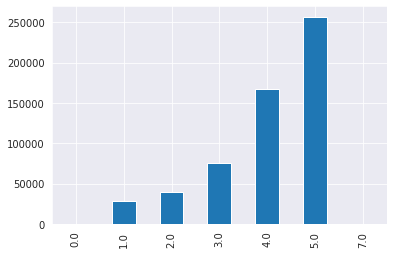

In [7]:
reviews.rating.value_counts().sort_index().plot.bar();